# Sentiment Analysis- Ανάλυση Συναισθήματος
Στο παρόν μέρος της εργασίας, συμβουλευόμενοι και τις διαλέξεις του μαθήματος, θα πραγματοποιήσουμε sentiment analysis στα tweet που έχουμε διαθέσιμα σαν δεδομένα.

## Προετοιμασία
Στο παρόν μέρος της εργασίας θα κάνουμε import τις απαραίτητες βιβλιοθήκες και θα προχωρήσουμε στην φόρτωση του emolex που παραίχεται από τις διαλέξεις.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string
import glob
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!python -m spacy download el_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.6 MB 14.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')


In [ ]:
import spacy
nlp = spacy.load('el_core_news_sm')

In [ ]:
filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"
emolex_df = pd.read_csv(filepath)
emolex_df.head()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ενορκη βεβαιωση,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,εχοντας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,εχω,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,οριο,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(inplace = True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Στη συνέχεια θα φορτώσουμε στο σύστημα τα δεδομένα από τα tweets που έχουμε στη διάθεσή μας.

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/final/ioanna/data_final.csv')
data.head()

,date,followers,retweetcount,text,year,month,day,initial_character_lenght,most_frequent_word,most_frequent_bigramm
0,2022-07-03 13:42:00,1749,2,κάθε άτομο με μήτρα πρέπει να έχει δικαίωμα στ...,2022,7,3,201,σας,"κάθε,άτομο"
1,2022-07-03 13:35:12,28,2,κάθε άτομο με μήτρα πρέπει να έχει δικαίωμα στ...,2022,7,3,201,σας,"κάθε,άτομο"
2,2022-07-03 13:26:31,7190,2,όταν η μαρία κυπριωτάκη περνούσε τον νόμο για ...,2022,7,3,130,όταν,"όταν,μαρία"
3,2022-07-03 13:24:00,2399,6,επειδή τίποτε δεν είναι αυτονόητο &amp; δεν έ...,2022,7,3,269,επειδή,"επειδή,τίποτε"
4,2022-07-03 13:13:20,1511,7,σήμερα (3/7) στις 20.30 στην κατάληψη λέλας κα...,2022,7,3,308,στις,"σήμερα,στις"


In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%Y %m %d %H:%M:%S')

In [ ]:
data.dtypes

date                        datetime64[ns]
followers                            int64
retweetcount                         int64
text                                object
year                                 int64
month                                int64
day                                  int64
initial_character_lenght             int64
most_frequent_word                  object
most_frequent_bigramm               object
dtype: object

In [ ]:
data.head()

,date,followers,retweetcount,text,year,month,day,initial_character_lenght,most_frequent_word,most_frequent_bigramm
0,2022-07-03 13:42:00,1749,2,κάθε άτομο με μήτρα πρέπει να έχει δικαίωμα στ...,2022,7,3,201,σας,"κάθε,άτομο"
1,2022-07-03 13:35:12,28,2,κάθε άτομο με μήτρα πρέπει να έχει δικαίωμα στ...,2022,7,3,201,σας,"κάθε,άτομο"
2,2022-07-03 13:26:31,7190,2,όταν η μαρία κυπριωτάκη περνούσε τον νόμο για ...,2022,7,3,130,όταν,"όταν,μαρία"
3,2022-07-03 13:24:00,2399,6,επειδή τίποτε δεν είναι αυτονόητο &amp; δεν έ...,2022,7,3,269,επειδή,"επειδή,τίποτε"
4,2022-07-03 13:13:20,1511,7,σήμερα (3/7) στις 20.30 στην κατάληψη λέλας κα...,2022,7,3,308,στις,"σήμερα,στις"


In [ ]:
print(data.text[2])

όταν η μαρία κυπριωτάκη περνούσε τον νόμο για τις αμβλώσεις στην ελλάδα -οι αντιδράσεις της αντιπολίτευσης https://t.co/bcdh5fhsfl


In [ ]:
to_be_removed=list(string.punctuation)
to_be_removed.extend(["«", "»", "\n", '\\', "'\'", ":", "/", "//", "https:", ": ","1","2","3","4","5","6","7","8","9","0"])

alphabet_string = list(string.ascii_lowercase)
#alphabet_string=alphabet_string.extend(string.ascii_uppercase)
to_be_removed.extend(alphabet_string)
to_be_removed.extend(string.ascii_uppercase)
print(to_be_removed)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '«', '»', '\n', '\\', "''", ':', '/', '//', 'https:', ': ', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
def tweet_process(twt):
  nopunc=[char for char in twt if char not in to_be_removed]
  nopunc="".join(nopunc)
  nopunc=nopunc.replace(r'https?:\/\/.*[\r\n]*'," ")
  nopunc=nopunc.replace(r'[\n.:,]'," ")
  nopunc=nopunc.replace(r'[#.]'," ")
  nopunc=nopunc.replace(r'[/.]', " ")
  nopunc=nopunc.replace('€', " ")
  return [word for word in nopunc.split() if word not in stopwords.words('greek')]

In [ ]:
print(data['text'][2])

όταν η μαρία κυπριωτάκη περνούσε τον νόμο για τις αμβλώσεις στην ελλάδα -οι αντιδράσεις της αντιπολίτευσης https://t.co/bcdh5fhsfl


In [ ]:
print(tweet_process(data['text'][2]))

['όταν', 'μαρία', 'κυπριωτάκη', 'περνούσε', 'νόμο', 'αμβλώσεις', 'ελλάδα', 'αντιδράσεις', 'της', 'αντιπολίτευσης']


In [ ]:
#data['text_final']=np.nan
## data['text_final'].iloc[i,9]=" ".join(tweet_process(data['text'][i]))


def final_text(serie_record):
  return " ".join(tweet_process(serie_record))

data['text_final']=data['text'].apply(final_text)

In [ ]:
data.head()

,date,followers,retweetcount,text,year,month,day,initial_character_lenght,most_frequent_word,most_frequent_bigramm,text_final
0,2022-07-03 13:42:00,1749,2,κάθε άτομο με μήτρα πρέπει να έχει δικαίωμα στ...,2022,7,3,201,σας,"κάθε,άτομο",κάθε άτομο μήτρα πρέπει έχει δικαίωμα άμβλωση ...
1,2022-07-03 13:35:12,28,2,κάθε άτομο με μήτρα πρέπει να έχει δικαίωμα στ...,2022,7,3,201,σας,"κάθε,άτομο",κάθε άτομο μήτρα πρέπει έχει δικαίωμα άμβλωση ...
2,2022-07-03 13:26:31,7190,2,όταν η μαρία κυπριωτάκη περνούσε τον νόμο για ...,2022,7,3,130,όταν,"όταν,μαρία",όταν μαρία κυπριωτάκη περνούσε νόμο αμβλώσεις ...
3,2022-07-03 13:24:00,2399,6,επειδή τίποτε δεν είναι αυτονόητο &amp; δεν έ...,2022,7,3,269,επειδή,"επειδή,τίποτε",επειδή τίποτε είναι αυτονόητο έγινε μονο πασοκ...
4,2022-07-03 13:13:20,1511,7,σήμερα (3/7) στις 20.30 στην κατάληψη λέλας κα...,2022,7,3,308,στις,"σήμερα,στις",σήμερα στις κατάληψη λέλας καραγιάννη προβολή ...


## Μετατροπή δεδομένων από αλφαριθμητικά σε αιρμητικά (vectorization)

In [ ]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',  
                      stop_words= nlp.Defaults.stop_words,
                      ngram_range=(1, 2))

In [ ]:
matrix = vec.fit_transform(data['text_final'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'απο', 'αποψε', 'αρα', 'αραγε', 'αρκετα', 'αρκετες', 'αρχικα', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
wordcount_df.shape

(824, 13161)

In [ ]:
# Φτιάξε μια λίστα με positive words

angry_words = emolex_df[emolex_df.Anger == 1]['word']

positive_words = emolex_df[emolex_df.Positive == 1]['word']


# Φτιάξε μια λίστα με sadness words
sadness_words = emolex_df[emolex_df.Sadness == 1]['word']


# Φτιάξε μια λίστα με surprise words
surprise_words = emolex_df[emolex_df.Surprise == 1]['word']


# Φτιάξε μια λίστα με disgust words
disgust_words = emolex_df[emolex_df.Disgust == 1]['word']


# Φτιάξε μια λίστα με anticipation words
anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']


# Φτιάξε μια λίστα με negative words
negative_words = emolex_df[emolex_df.Negative == 1]['word']



# Φτιάξε μια λίστα με joy words
joy_words = emolex_df[emolex_df.Joy == 1]['word']


# Φτιάξε μια λίστα με trust words
trust_words = emolex_df[emolex_df.Trust == 1]['word']



# Φτιάξε μια λίστα με fear words
fear_words = emolex_df[emolex_df.Fear == 1]['word']

In [ ]:
data['anger'] = wordcount_df[angry_words].sum(axis=1)

data['positivity'] = wordcount_df[positive_words].sum(axis=1)

data['joy'] = wordcount_df[joy_words].sum(axis=1)

data['disgust'] = wordcount_df[disgust_words].sum(axis=1)



data['surprise'] = wordcount_df[surprise_words].sum(axis=1)

data['trust'] = wordcount_df[trust_words].sum(axis=1)


data['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)


data['sadness'] = wordcount_df[sadness_words].sum(axis=1)

data['negative'] = wordcount_df[negative_words].sum(axis=1)

data['fear'] = wordcount_df[fear_words].sum(axis=1)

In [ ]:
data

,date,followers,retweetcount,text,year,month,day,initial_character_lenght,most_frequent_word,most_frequent_bigramm,...,anger,positivity,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
0,2022-07-03 13:42:00,1749,2,κάθε άτομο με μήτρα πρέπει να έχει δικαίωμα στ...,2022,7,3,201,σας,"κάθε,άτομο",...,0,3,1,2,0,1,1,1,2,1
1,2022-07-03 13:35:12,28,2,κάθε άτομο με μήτρα πρέπει να έχει δικαίωμα στ...,2022,7,3,201,σας,"κάθε,άτομο",...,0,3,1,2,0,1,1,1,2,1
2,2022-07-03 13:26:31,7190,2,όταν η μαρία κυπριωτάκη περνούσε τον νόμο για ...,2022,7,3,130,όταν,"όταν,μαρία",...,0,0,0,0,0,0,0,0,0,0
3,2022-07-03 13:24:00,2399,6,επειδή τίποτε δεν είναι αυτονόητο &amp; δεν έ...,2022,7,3,269,επειδή,"επειδή,τίποτε",...,0,0,0,0,0,0,0,0,0,0
4,2022-07-03 13:13:20,1511,7,σήμερα (3/7) στις 20.30 στην κατάληψη λέλας κα...,2022,7,3,308,στις,"σήμερα,στις",...,1,2,1,0,0,1,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,2022-06-29 13:35:35,5492,9,"γέροντας μεθόδιος: “η εκκλησία τι κάνει, ποιος...",2022,6,29,246,στις,"γέροντας,μεθόδιος",...,0,2,1,0,0,2,2,0,0,0
820,2022-06-29 13:30:57,9035,0,αδιανόητη δήλωση ιερέα για τις αμβλώσεις: τουλ...,2022,6,29,131,αδιανόητη,"αδιανόητη,δήλωση",...,0,1,0,0,0,1,0,0,0,0
821,2022-06-29 13:30:53,3093,0,έλληνας γιδοβαλκανιος παραθέτει αποψαρα για #α...,2022,6,29,129,τους,"έλληνας,γιδοβαλκανιος",...,0,0,0,0,0,0,0,0,0,0
822,2022-06-29 13:25:47,323,0,τα 7 θανάσιμα δικαιώματα του νεοφιλελέ: 1. αμβ...,2022,6,29,304,φασíστες,"θανάσιμα,δικαιώματα",...,1,0,0,1,0,0,0,1,1,1


In [ ]:
data.set_index('date' , inplace=True)

In [ ]:
data.columns

Index(['followers', 'retweetcount', 'text', 'year', 'month', 'day',
       'initial_character_lenght', 'most_frequent_word',
       'most_frequent_bigramm', 'text_final', 'anger', 'positivity', 'joy',
       'disgust', 'surprise', 'trust', 'anticipation', 'sadness', 'negative',
       'fear'],
      dtype='object')

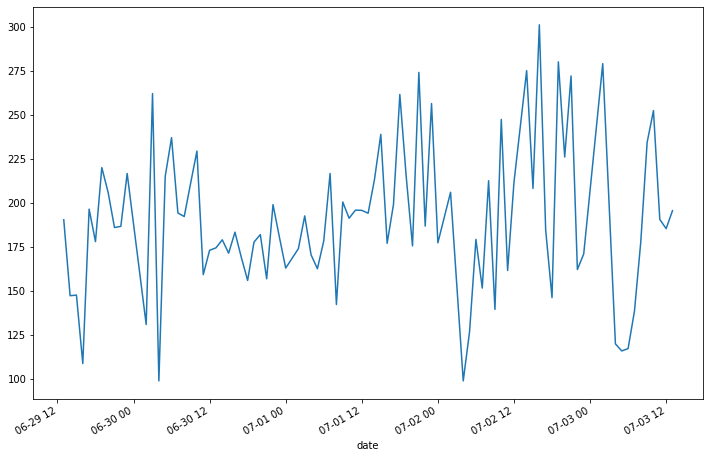

In [ ]:
data['text'].str.len().resample('H').mean().dropna().plot(figsize=(12,8)) 

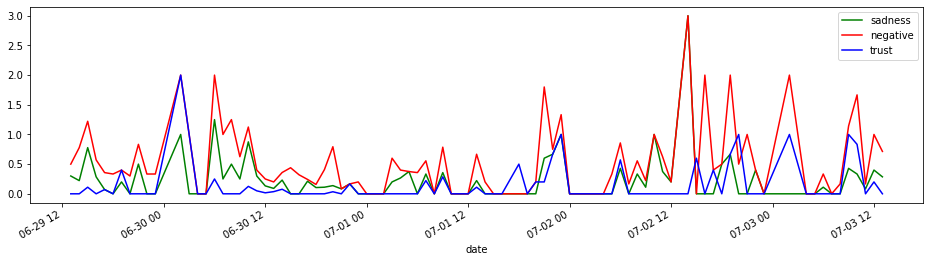

In [ ]:
ax = data['sadness'].resample('H').mean().dropna().plot(figsize=(16,4), 
                                                          color = 'g', legend=True)
data['negative'].resample('H').mean().dropna().plot(figsize=(16,4), ax = ax, 
                                                    color = 'r', legend=True)
data['surprise'].resample('H').mean().dropna().plot(figsize=(16,4), ax = ax, 
                                                label = 'trust',color = 'blue', legend=True)

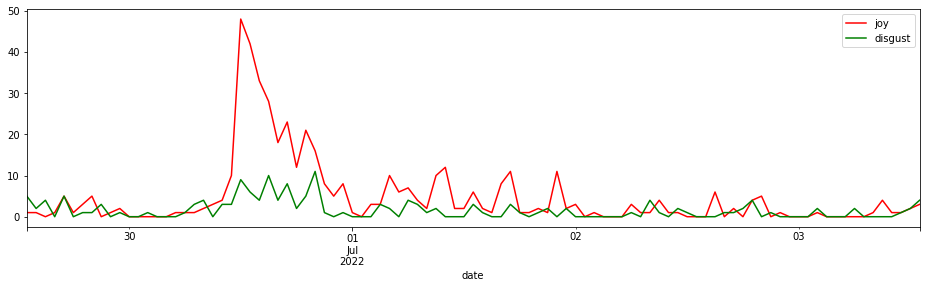

In [ ]:
ax = data['joy'].resample('H').sum().plot(figsize=(16,4), color = 'red', legend=True)
data['disgust'].resample('H').sum().plot(figsize=(16,4), ax = ax, color = 'green', legend=True)
